In [1]:
import tensorflow as tf

# Vérifiez si une GPU est disponible
if tf.config.list_physical_devices('GPU'):
    # Assurez-vous que TensorFlow utilise la GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('TensorFlow utilise la GPU.')
else:
    print('Aucune GPU n\'est disponible.')

2023-09-11 14:39:54.355500: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 14:39:54.356581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 14:39:54.379086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 14:39:54.379713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 14:39:54.899263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Aucune GPU n'est disponible.


2023-09-11 14:39:55.486005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-11 14:39:55.486337: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
!nvidia-smi

Mon Sep 11 14:33:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0  On |                  N/A |
| 34%   38C    P3              31W / 125W |    495MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# créer un dossier dans lequel il faut mettre le dossier \images et \masks
# Pour la partie entrainnement les fichiers utilisés sont les *_gtFine_labelIds.png)

# Monter le drive dans google colab
# Suivre les istructions choix du compte google et donner l'authorisation
from google.colab import drive
drive.mount('/content/data')

#-- Pour démonter le drive
# data.flush_and_unmount()

Mounted at /content/data


In [ ]:
# Copy des dichiers dans google colab
!cp -r /content/data/MyDrive/ColabNotebooks/Openclassrooms/P8_AI_program/sample2 /content

In [ ]:
#!rm -r '/content/sample2'
#!rm -r '/content/sample2b'

In [ ]:
# *** Duplicate /sample2 to /sample2b
import shutil

def duplicate_folder(source_folder, destination_folder):
    try:
        # Copy the entire folder and its contents to the destination
        shutil.copytree(source_folder, destination_folder)
        print(f"Folder '{source_folder}' duplicated to '{destination_folder}' successfully.")
    except Exception as e:
        print(f"Error: {e}")

source_folder = '/content/sample2'
destination_folder = '/content/sample2b'

#!rm -r '/content/sample2b'
duplicate_folder(source_folder, destination_folder)

Folder '/content/sample2' duplicated to '/content/sample2b' successfully.


In [ ]:
# Folders definition
# A spécifier les chemins appropriés !!
TRAIN_IMAGES_FOLDER = '/content/sample2b/train/images'
TRAIN_MASKS_FOLDER = '/content/sample2b/train/masks'
#
VAL_IMAGES_FOLDER = '/content/sample2b/val/images'
VAL_MASKS_FOLDER = '/content/sample2b/val/masks'

## Generator and Aug

In [ ]:
#Example  Augmentation des données
# http://imgaug.readthedocs.io/
import imgaug as ia
from imgaug import augmenters as iaa

#
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

In [ ]:
#Augmentation des données
# http://imgaug.readthedocs.io/
import imgaug as ia
from imgaug import augmenters as iaa

def get_augmentation_function():
  l_fct = iaa.Sometimes(0.5,
      iaa.GaussianBlur(sigma=2.0),
      iaa.OneOf([
      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
      iaa.Sequential([iaa.HistogramEqualization(),iaa.Rotate((-45, 45)) ])])
  )
  #
  return l_fct #augmenters.Rotate((-45, 45))

In [ ]:
def get_augmentation(_img_array, _mask_array):
    l_aug_fct = get_augmentation_function()
    aug_det = l_aug_fct.to_deterministic()

    image_aug = aug_det.augment_image(_img_array)

    segmap = ia.SegmentationMapsOnImage(_mask_array, shape=_img_array.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr()

    return image_aug, segmap_aug

In [ ]:
# Generator

import cv2
import glob
from tensorflow.keras.utils import Sequence
# Générateur sous forme de classe

'''
# image_dir : str, chemin images
# mask_dir : str, chamin  masks
# batch_size : int, taille du batch
# img_height : int, hauteur de l'image
# img_width : int, largeur de l'image
# is_augmentation : Gestion Augmentation
'''

class generator(Sequence):

    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 is_augmentation=False):
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.is_augmentation = is_augmentation

        # déclaration des chemins d'accès des images sous forme de liste
        image_list = glob.glob(os.path.join(image_dir, "*", "*.png"))

        # déclaration des chemins d'accès des masques sous forme de liste
        mask_list = glob.glob(os.path.join(mask_dir, "*", "*_gtFine_labelIds.png"))

        # Trie des listes dans l'ordre croissant
        image_list.sort()
        mask_list.sort()
        #
        self.image_list =  image_list
        self.mask_list =  mask_list

        print("Selection de {} images dans {}".format(len(self.image_list), self.image_dir))
        print("Selection de {} masks dans {}".format(len(self.mask_list), self.mask_dir))

    def __len__(self):
        return int(np.ceil(len(self.image_list) / float(self.batch_size)))

    # Méthode appelée à chaque fois q'un batch est demandé
    def __getitem__(self, idx):
        'génération un batch avec un index aléatoire'

        #Génération d'index aléatoire pour le batch
        idx = np.random.randint(0,len(self.image_list)-1, self.batch_size)

        # Initialisation de listes vides: images et les masques du batch
        batch_img, batch_mask = [], []

        # Balayage de tous les idx
        for i in idx:

            # Récupération du nom de l'image et du masque
            img_file = self.image_list[i]
            mask_file = self.mask_list[i]


            # Redimensionnement des images (self.img_height, self.img_height)
            # Tailles d'origine (1024 x 2048)
            img_array  = cv2.resize(cv2.imread(img_file),
                                (self.img_width, self.img_height))
            mask_array = cv2.resize(cv2.imread(mask_file),
                                (self.img_width, self.img_height))

            segmap_aug = mask_array
            # Conversion du masque en échelle de gris (grayscale)
            segmap_aug_grey = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)
            # Conversion du mask
            mask_num = get_numpy_mask_from_image(mask_img = segmap_aug_grey)

            # Ajout des images et masques à la liste
            batch_img.append(img_array)
            batch_mask.append(mask_num)

            # if augmentation
            if self.is_augmentation:
              image_aug, segmap_aug = get_augmentation(img_array,mask_array)

              # Conversion du masque en échelle de gris (grayscale)
              segmap_aug_grey = cv2.cvtColor(segmap_aug, cv2.COLOR_BGR2GRAY)
              # Conversion du mask
              mask_aug = get_numpy_mask_from_image(mask_img = segmap_aug_grey)

              # Ajout des images et masques à la liste
              batch_img.append(image_aug)
              batch_mask.append(mask_aug)

        #
        l_lst_batch_img_mask = (np.array(batch_img).astype(np.float32),
                                    np.array(batch_mask).astype(np.float32))
        #
        return l_lst_batch_img_mask

In [ ]:
# train_model function()

from tensorflow.keras.models import Model
#
from tensorflow.keras.metrics import BinaryIoU, BinaryAccuracy
METRICS_LIST = [BinaryAccuracy(name="binary_accuracy"), BinaryIoU(name="binary_iou")]
METRICS_LIST = [BinaryIoU(name="binary_iou")]
#
from tensorflow.keras.callbacks import EarlyStopping
early_stop   = EarlyStopping(monitor='val_loss', patience=7) #patience=5
#
EPOCH_NUMBER = 150
BATCH_SIZE = 8
TRAINING_IMAGE_WIDTH = 256
TRAINING_IMAGE_HEIGHT = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
#
WORKERS_NB = 6

# A tester quelques optimizers: Adam, SGD, RMSprop,
                            #Adadelta, Adagrad, Adamax, Nadam
# example: RMSprop
rms=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,rho=0.9,
                                       momentum=0.0, epsilon=1e-07,
                                       centered=False, name='RMSprop')

OPTIMIZER = rms

def train_model(segmentation_model, segmentation_model_name,
                backbone_model, loss_type, _EPOCH_NUMBER = EPOCH_NUMBER,
                is_augmentation=False):

    input_size = (TRAINING_IMAGE_WIDTH, TRAINING_IMAGE_HEIGHT)

    print("Go train_model {} avec le décodeur {} et des images de taille {}x{}"
                          .format(segmentation_model_name, backbone_model,
                                  input_size[0], input_size[1]))
    print('is_augmentation= ', is_augmentation)

    # Training_model
    training_model = segmentation_model(backbone_model,
                                        encoder_weights='imagenet',
                                        input_shape=(input_size[1],
                                                     input_size[0], 3),
                                        classes=8)
    training_model.summary()

    training_model.compile(loss=loss_type, optimizer=OPTIMIZER,
                           metrics=METRICS_LIST)


    # Création du  train et validation generator pour l'entrainement
    train_generator = generator(image_dir  = TRAIN_IMAGES_FOLDER,
                                         mask_dir   = TRAIN_MASKS_FOLDER,
                                         batch_size = BATCH_SIZE,
                                         img_height = input_size[1],
                                         img_width  = input_size[0],
                                         is_augmentation = is_augmentation)
    #
    validation_generator = generator(image_dir  = VAL_IMAGES_FOLDER,
                                              mask_dir   = VAL_MASKS_FOLDER,
                                              batch_size = BATCH_SIZE,
                                              img_height = input_size[1],
                                              img_width  = input_size[0],
                                              is_augmentation = False)

    # Lancement de l'entrainement
    history = training_model.fit(train_generator, epochs=_EPOCH_NUMBER, verbose=1,
                                 callbacks=[early_stop],
                                 validation_data=validation_generator,
                                 workers=WORKERS_NB,use_multiprocessing=True)
    #r
    return training_model

## Utils

In [ ]:
!pip install segmentation_models

In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


In [ ]:
from collections import namedtuple
#
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [ ]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [ ]:
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]
#category2labels

In [ ]:
# Fonction qui sert à extraire la matrice de segmentation masque

def get_numpy_mask_from_image(mask_img):
    mask_array   = np.zeros((mask_img.shape[0], mask_img.shape[1], 8),dtype=int) # Création d'un masque qu'avec des 0

    for k, v in category2labels.items():
        #print("[INFO] : Processing for main category ", k)
        for category_label in v:
            categoryId = category_label[4]
            labelID = category_label[1]
            #print("    [INFO] : Processing for subcategory {} (labelID = {} | categoryId={})".format(category_label[0], labelID, categoryId))
            mask_array[:,:,categoryId] = np.logical_or(mask_array[:,:,categoryId],(mask_img==labelID))

    return mask_array

In [ ]:
#Affichage des catégories et les labels associés
id_category     = { label[4]   : label.category for label in labels  }
id_category

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

In [ ]:
from matplotlib import colors
#
def generate_img_from_mask(mask,colors_palette=['b','g','r','c','m','y','k','w']):

    '''Génréation d'une image PIL depuis un masque segmenté et catégorie avec une couleur associée à chacune des catégories

    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}

    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')

    print("mask size :",mask.shape)
    print("img_seg size :",img_seg.shape)

    for cat in id_category.keys():
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]


    return img_seg

def affichage_result_mask(_img,_model):

    img_test_array  = cv2.imread(_img)

    resized = cv2.resize(img_test_array,(256,128))
    plt.imshow(resized )

    resized = np.expand_dims(resized, axis = 0)

    mask_u = _model.predict(resized)

    print(id_category.keys())

    print("mask_u.shape before squeeze: ",mask_u.shape)
    a_s = np.squeeze(mask_u)
    # print("mask_u.shape after squeeze: ",a_s)

    mask_t=generate_img_from_mask(a_s)
    #print(mask_t)
    plt.imshow(mask_t)

    return mask_t

## Training

In [ ]:
# ===== TRAINING --> Unet, ResNet34
import time
from segmentation_models.losses import jaccard_loss, dice_loss, \
                                            categorical_focal_loss, \
                                            categorical_crossentropy, \
                                            cce_dice_loss, \
                                            cce_jaccard_loss

t0 = time.time()
#
model = train_model(segmentation_model=Unet,
                          segmentation_model_name="unet",
                          backbone_model="resnet34",
                          loss_type=jaccard_loss,
                          # _EPOCH_NUMBER=1,
                          is_augmentation=False)

training_time = str(int((time.time() - t0)/60)) + " mn"
#
print('training_time: ' + training_time)


## Test

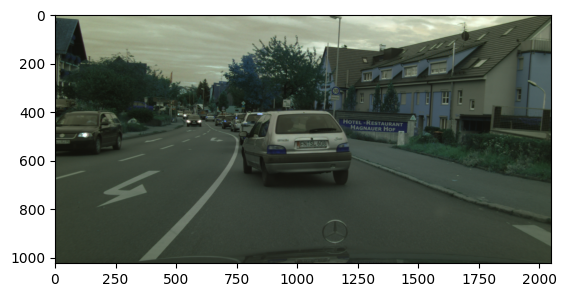

In [ ]:
# Image test

img_test = "/content/sample2b/val/images/lindau/lindau_000000_000019_leftImg8bit.png"

img_test_array  = cv2.imread(img_test)
plt.imshow(img_test_array)

1/1 [==============================] - 1s 841ms/step


dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
mask_u.shape before squeeze:  (1, 128, 256, 8)
mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


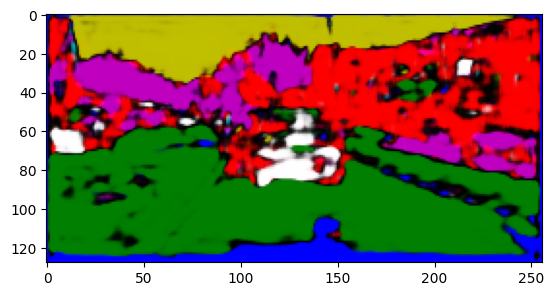

In [ ]:
#==== model 11/09 GPU val_binary_iou: 0.7922   15mn
mask_t=affichage_result_mask(img_test,model)

1/1 [==============================] - 0s 206ms/step


dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
mask_u.shape before squeeze:  (1, 128, 256, 8)
mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


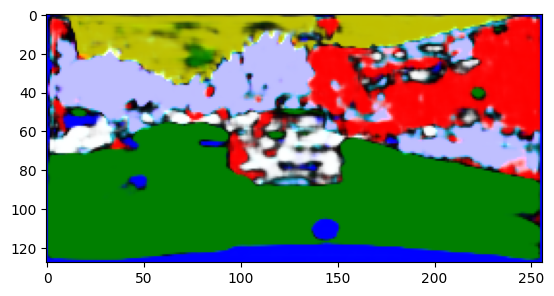

In [ ]:
#==== model 11/09  val_binary_iou: 0.7506  60mn
mask_t=affichage_result_mask(img_test,model)

1/1 [==============================] - 0s 245ms/step


dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
mask_u.shape before squeeze:  (1, 128, 256, 8)
mask_u.shape after squeeze:  (1, 128, 256, 8)
mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


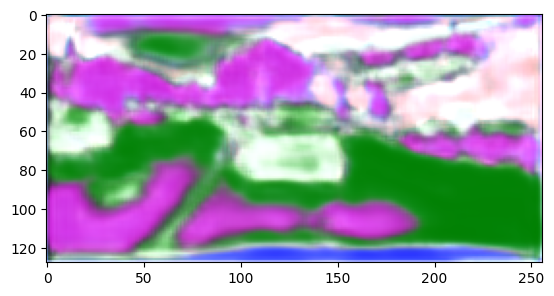

In [ ]:
#==== model  10/09
mask_t=affichage_result_mask(img_test,model)